# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [2]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 
                                  'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('zillow_data.csv')
df.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


In [5]:
melt_df = melt_data(df)
# melt_df.set_index('time', inplace=True)
melt_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)
melt_df.tail()

,RegionName,City,State,Metro,CountyName,time,value
3901590,1338,Ashfield,MA,Greenfield Town,Franklin,2018-04-01,209300.0
3901591,3293,Woodstock,NH,Claremont,Grafton,2018-04-01,225800.0
3901592,40404,Berea,KY,Richmond,Madison,2018-04-01,133400.0
3901593,81225,Mount Crested Butte,CO,NaN,Gunnison,2018-04-01,664400.0
3901594,89155,Mesquite,NV,Las Vegas,Clark,2018-04-01,357200.0


In [6]:
# sort by zip code and date
sorted_melt = melt_df.sort_values(['RegionName', 'time'])
sorted_melt.head()

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0


# Step 2: Data Preprocessing

In [7]:
# create a new dataframe with the difference between the values in recent years after the housing crisis
series09 = df['2009-04']
series18 = df['2018-04']
zipcode = df['RegionName']

# add the difference and noramalize it
diff_df = pd.concat([zipcode, series09, series18], axis=1)
diff_df['diff'] = (diff_df['2018-04'] - diff_df['2009-04'])/diff_df['2009-04']*100

# diff_df.hist('diff',bins=20, density=True)

In [8]:
cutoffs = [diff_df['diff'].quantile(0.05),
          diff_df['diff'].quantile(0.95)]
cutoffs

[-7.3194206740281125, 69.3212732041648]

In [9]:
# # Scale the values
# scaler = MinMaxScaler()
# melt_df[['value']] = scaler.fit_transform(melt_df[['value']])

In [10]:
# grab the zip codes that exist between the cutoff values
zips_model_1 = diff_df[diff_df['diff']<cutoffs[0]]['RegionName']
zips_model_10 = diff_df[diff_df['diff']>cutoffs[1]]['RegionName']

In [11]:
high_return = melt_df.loc[melt_df['RegionName'].isin(list(zips_model_10))]
low_return = melt_df.loc[melt_df['RegionName'].isin(list(zips_model_1))]

In [12]:
# dataframe for the very high returns to model
high_df = high_return.groupby('time')[['value']].mean()
low_df = low_return.groupby('time')[['value']].mean()

# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

,value
time,
1996-04-01,12.101794
1996-05-01,12.103429
1996-06-01,12.105220
1996-07-01,12.107178
1996-08-01,12.109452
1996-09-01,12.112157
1996-10-01,12.115628
1996-11-01,12.119705
1996-12-01,12.125298


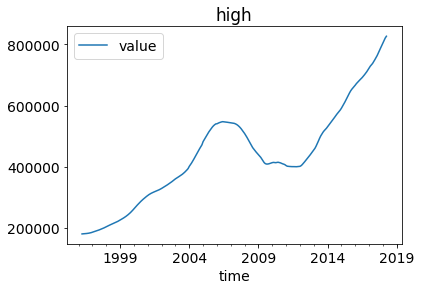

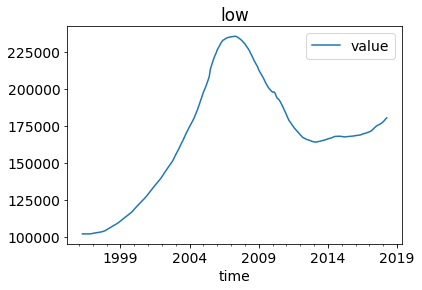

In [14]:
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
high_df.plot()
plt.title('high')
low_df.plot()
plt.title('low')
#log transform values
log_high = pd.DataFrame(np.log(high_df['value']), index=high_df.index)
# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [16]:
# dickey fuller test
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(array):
    test = adfuller(array)
    output = pd.Series(test[0:4], index = ['Test Stat','p-value','# Lags used', '# of obs'])
    return output

Test Stat     -1.422438e+01
p-value        1.636941e-26
# Lags used    0.000000e+00
# of obs       2.620000e+02
dtype: float64

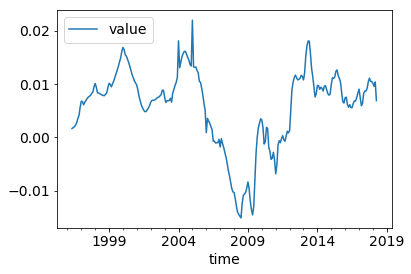

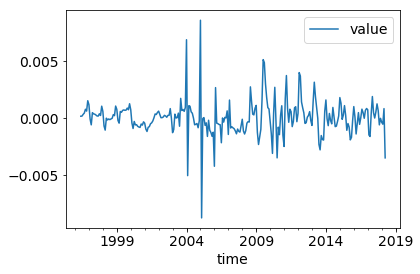

In [17]:
#differenced once
high_df_once = log_high.diff()
high_df_once.plot()
#differenced twice
high_df_twice = high_df_once.diff()
high_df_twice.plot()
high_df_twice.dropna(inplace=True)
#run dicky fuller
dickey_fuller(high_df_twice.value)

In [ ]:
output_high = dickey_fuller(high_df['value'])

In [ ]:
output_high

In [ ]:
output_low = dickey_fuller(low_df['value'])

In [ ]:
output_low

In [ ]:
# try log transforming the data
log_high = pd.Series(np.log(high_df['value']), index=high_df.index)

In [ ]:
dickey_fuller(log_high)

In [ ]:
# our p-values are larger than 0.05, so we cannot reject the Null and our data is not stationary
# so let's difference our data

diff_high = log_high.diff()

In [ ]:
diff_high

In [ ]:
diff_high.dropna(inplace=True)

In [ ]:
diff_high.plot()

In [ ]:
dickey_fuller(diff_high['value'])

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.